## Group Members:
152120181004 - Sıla Eşme\
152120191050 - Zeynep Gürlüzer

## Project: Money Classification

In [104]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.datasets import load_files
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from skimage.feature import hog, ORB
from skimage.color import rgb2gray
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

NUMBER_OF_DESC = 32
NUMBER_OF_BEST = 250

# 1. Data Loading

Data loading: 100%|██████████| 144/144 [00:00<00:00, 222.44it/s]


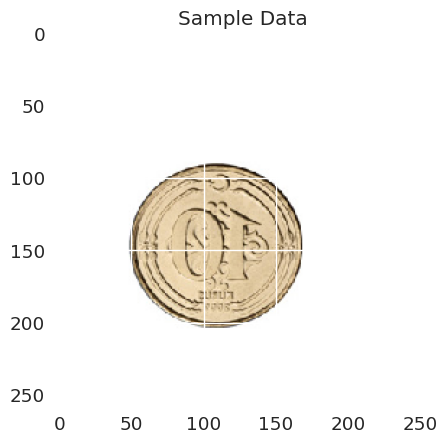

In [124]:
def loadImage(path):
  img = image.load_img(path, target_size = (256,256))
  return image.img_to_array(img)

def loadData(path):
  data = load_files(path)
  f = np.array(data['filenames'])
  t = np_utils.to_categorical(np.array(data['target']))
  f_arr = tqdm(f, desc='Data loading', leave=True)
  img_data = [loadImage(p)/255 for p in f_arr]
  return np.array(img_data), np.array(t)

x_train, y_train = loadData("/content/drive/MyDrive/MoneyClassification/TrainingImages")
x_test, y_test = loadData("/content/drive/MyDrive/MoneyClassification/TestImages")

plt.title("Sample Data")
plt.imshow(x_train[3])
plt.show()


# 2. Feature Extraction

In [106]:
def featureExtractionHOG(data):
  for image in data:
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(6, 6),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    plt.axis("off")
    plt.imshow(hog_image, cmap="gray")

def featureExtractionORB(data, n):
  li = []
  for image in data:
    gr_image = rgb2gray(image)
    descriptor_extractor = ORB(n_keypoints = n)
    descriptor_extractor.detect_and_extract(gr_image)
    descriptors = descriptor_extractor.descriptors
    li.append(descriptors)
  return np.array(li)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

d_train = featureExtractionORB(x_train, NUMBER_OF_DESC)
d_train = d_train.reshape((n_train, -1))

d_test = featureExtractionORB(x_test, NUMBER_OF_DESC)
d_test = d_test.reshape((n_test, -1))

# 3. Feature Selection

In [108]:
def featureSelection(x_data, y_data, n):
  slct = SelectKBest(score_func=chi2, k=n).fit_transform(x_data, y_data)
  return slct

s_train = featureSelection(d_train, y_train, NUMBER_OF_BEST)
print(f'After Selection, shape of train data = {s_train.shape}')

s_test = featureSelection(d_test, y_test, NUMBER_OF_BEST)
print(f'After Selection, shape of test data = {s_test.shape}')

After Selection, shape of train data = (300, 250)
After Selection, shape of test data = (144, 250)


# 4. Train Classifier

In [109]:
def trainClassifier(x_data, y_data):
  svm = OneVsRestClassifier(SVC(probability=True)).fit(x_data, y_train)
  return svm

train = trainClassifier(s_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(


# 5. Predict

In [ ]:
def predictClassifier(svm, x_test):
  return svm.predict(x_test)

predict = predictClassifier(train, s_test)

# 6. Accuracy, Confusion Matrix, F-Score, Roc Auc Score

accuracy => 0.8611111111111112

F-score => [0.0, 0.4, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.9565217391304348, 1.0, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348]

Roc auc-score => 1.0

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.25      0.40        12
           2       1.00      0.50      0.67        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       1.00      0.92      0.96        12
           8       1.00      1.00      1.00        12
           9       1.00      0.92      0.96        12
          10       1.00      0.92      0.96        12
          11       1.00      0.92      0.96        12
          12       1.00      0.92      0.96       

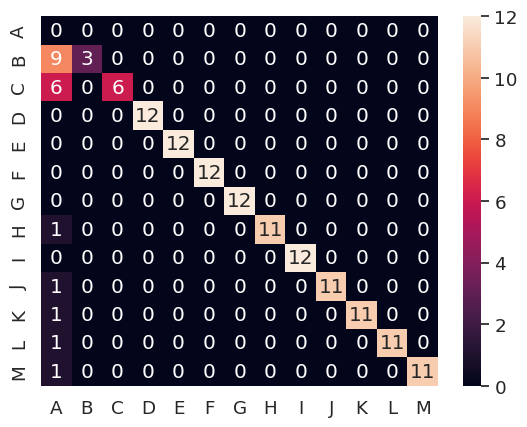

In [154]:
import warnings
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

print(f'accuracy => {str (accuracy_score(y_test, predict))}\n')

print(f'F-score => {list(f1_score(y_test, predict, average=None))}\n')

clf = LogisticRegression(solver="liblinear").fit(s_train, y_train.argmax(1))
print(f'Roc auc-score => {roc_auc_score(y_train.argmax(1), clf.predict_proba(s_train), multi_class="ovr")}\n')

print(f'Classification Report: \n {classification_report(y_test, predict)}')


print('\nConfusion Matrix: \n')
cm = confusion_matrix(y_test.argmax(1), predict.argmax(1))
df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJKLM"],  columns = [i for i in "ABCDEFGHIJKLM"])
sn.set(font_scale= 1.2)
sn.heatmap(df_cm, annot= True)
plt.show()

